## Function classes

Considere F, a classe de funcoes que uma arquitetura de rede pode chegar. Isso e, para todo f pertencente a F existe um conjunto de parametros que pode obter atraves de treinamento em um dataset suitable. Iremos assumir que f*  e a verdadeira funcao que realmente gostariamos de encontrar. Se tentarmos encontrar algum f*F no qual nossa melhor aposta dentro de F. por exemplo, dado um dadtaset com x features e y labels, podemos tentar achar ela resolvendo a seguinte otimizacao: <br> <br>
f*F = argminL(X, y, f)  subject tto f pertencente a F <br> <br>
Sabemos que a regularizacao pode controlar a complexidade de F e chegar a consistencia, entao uma maior quantidade de dados de treino geralmente leva a um melhor f*F. E razoavel assumir que se desenharmos uma arquitetura mais poderosa e diferente F' chegariamos em um resultado melhor. Em outras palavras, esperamos que f*F, e melhor que f*F de toda formase F nao contem F' nao a garantia que isso aconteca. Na verdade f*F pode ate mesmo ser pior como na figura 8.6.1, para funcoes de classes nao encadeadas, uma funcao de classe encadeada nsem sempree se move para a verdadeira funcao f*. Na imagem podemos ver que as funcoes nao encadeadas temos f3 mais proximo de f* e que aumentar a complexidade nem sempre leva a mais proximo dela. Mas podemos ver que em funcoes encadeadas isso pode ser verdade. Entao, apenas se funcoes classes maiores conterem a menor entao garantimos  que aumentanto e estritamente aumentando o poder da reda. Para deep neural networks, se conseguirmos treinar o novo layer adicionado na sua funcao identidade f(x) = x, o novo modelo vai ser tao efetivo quanto o mdoelo original. Enquanto o modelo novo pode conseguir melhor solucoes para fittar o dataset de treino, o layer adicionado pode tornar mais facil reduzir erros de treino.

## Residual Blocks

Denote o input por X. Assumimos que o mapeamento desejado e obtido por aprendendo f(X), para ser usado como input da funcao de ativacao. Nos modelos anteriores o model aprende com f(X) contudo com resnets adicionamos o input a g(X) e assim obtemos f(X) -> g(X) = f(X) + X<br>
g(X) = 0

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 29.8 MB/s 


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchmetrics import Accuracy

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class Residual(nn.Module):
  def __init__(self, n_channels, use_1x1conv = False, strides = 1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(n_channels, kernel_size = 3, padding = 1, stride = strides)
    self.conv2 = nn.LazyConv2d(n_channels, kernel_size = 3, padding = 1)
    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(n_channels, kernel_size = 1, stride = strides)
    else:
      self.conv3 = None

    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [5]:
blk = Residual(3).to(device)
X = torch.randn(4, 3, 6, 6).to(device)
blk(X).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

In [6]:
class ResNet(nn.Module):
  def __init__(self, arch, lr = 0.1, n_classes = 10):
    super(ResNet, self).__init__()
    self.arch = arch
    self.lr = lr
    self.n_classes = n_classes
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
      self.net.add_module(f'b{i+2}', self.block(*b, first_block = (i == 0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(n_classes)
    ))
  
  def block(self, n_residuals, n_channels, first_block = False):
    blk = []
    for i in range(n_residuals):
      if i == 0 and not first_block:
        blk.append(Residual(n_channels, use_1x1conv = True, strides = 2))
      else:
        blk.append(Residual(n_channels))
    return nn.Sequential(*blk)

  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size = 7, stride = 2, padding = 3),
        nn.LazyBatchNorm2d(),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    )

  def forward(self, X):
    return self.net(X)

In [7]:
class ResNet18(ResNet):
  def __init__(self, lr = 0.1, n_classes = 10):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, n_classes)

In [8]:
model = ResNet18(lr = 0.01).to(device)

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import Compose

In [10]:
transform = Compose(
    [Resize((224, 224)),
    ToTensor()]
)

In [11]:
train_data = FashionMNIST(root = './data', train = True,
                          transform = transform, target_transform = None,
                          download = True)

test_data = FashionMNIST(root = './data', train = False,
                          transform = transform, target_transform = None,
                          download = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [12]:
torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = True)

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
acc = Accuracy(task = 'multiclass', num_classes = 10).to(device)

In [14]:
def train_step(model, train_loader, criterion, optimizer, acc, device):
  train_loss = 0
  train_acc = 0

  for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    preds = model(X)
    loss = criterion(preds, y)
    train_loss += loss.item()
    train_acc += acc(preds, y).item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  return train_loss, train_acc

In [15]:
def test_step(model, test_loader, criterion, acc, device):
  test_loss = 0
  test_acc = 0

  model.eval()
  with torch.inference_mode():
    for X, y in train_loader:
      X, y = X.to(device), y.to(device)
      preds = model(X)
      test_loss += criterion(preds, y).item()
      test_acc += acc(preds, y).item()

  test_loss /= len(test_loader)
  test_acc /= len(test_loader)

  return test_loss, test_acc

In [16]:
from tqdm import tqdm

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, acc, device)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_loss, test_acc = test_step(model, test_loader, criterion, acc, device)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

100%|██████████| 3/3 [11:18<00:00, 226.13s/it]


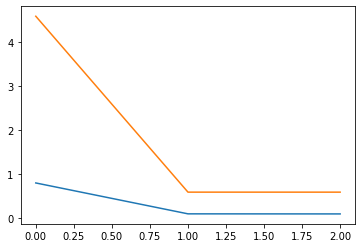

In [18]:
plt.plot(range(epochs), train_accs)
plt.plot(range(epochs), test_accs)

In [22]:
class ResNexBlock(nn.Module):
  def __init__(self, n_channels, groups, bot_mul, use_1x1conv = False, strides = 1):
    super().__init__()
    bot_channels = int(round(n_channels * bot_mul))
    self.conv1 = nn.LazyConv2d(bot_channels, kernel_size = 1, stride = 1)
    self.conv2 = nn.LazyConv2d(bot_channels, kernel_size = 3, stride = strides, padding = 1, groups = bot_channels // groups)
    self.conv3 = nn.LazyConv2d(n_channels, kernel_size = 1, stride = 1)

    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
    self.bn3 = nn.LazyBatchNorm2d()

    if use_1x1conv:
      self.conv4 = nn.LazyConv2d(n_channels, kernel_size = 1, stride = strides)
      self.bn4 = nn.LazyBatchNorm2d()
    else:
      self.conv4 = None
    
  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = F.relu(self.bn2(self.conv2(Y)))
    Y = self.bn3(self.conv3(Y))
    if self.conv4:
      X = self.bn4(self.conv4(X))
    return F.relu(Y + X)

In [23]:
blk = ResNexBlock(32, 16, 1).to(device)
X = torch.randn(4, 32, 96, 96).to(device)
blk(X).shape

torch.Size([4, 32, 96, 96])